In [3]:
#Set this variable to directory containing CONET executable
bin_dir = './'
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from numpy import genfromtxt
import conet 
import conet.src.data_converter.data_converter as dc
import conet.src.conet as c
import conet.src.conet_parameters as cp
import conet.src.inference_result as ir
import conet.src.per_bin_model as pb

In [5]:
def generate_model(tree_size, loci, cells, id_):
    cn_s = \
        pb.CNSampler({0:0.020240121,1: 0.203724532,3: 0.050340118,4: 0.038828672, 2: 0.686866557},
                  {0:0.449,1: 0.116,2: 0.187,3: 0.114,4: 0.279,5: 0.0957,6: 0.4833,7: 0.2760,8: 6.15780,9: 4.72105270})
    t_gen = pb.TreeGenerator(cn_s)
    tree, trunk = t_gen.generate_random_tree(loci, tree_size)
    d_gen = pb.CountsGenerator(cn_s)
    data = d_gen.generate_data(loci, tree, cells, trunk)
    np.savetxt("models/diffs_" + id_, data[3], delimiter=";", fmt='%.6f')
    np.savetxt("models/counts_" + id_, data[0], delimiter=";", fmt='%.6f')
    np.savetxt("models/corrected_counts_" + id_, data[2], delimiter=";", fmt='%.6f')
    np.savetxt("models/attachment_" + id_, data[1], delimiter=";", fmt='%.0f')
    nx.write_edgelist(tree, "models/tree_" + id_)
    return data, tree

In [6]:
def save_counts_in_CONET_format(path, counts, no_loci, no_cells):
    counts = np.transpose(counts)
    add = np.zeros([no_loci, 4], dtype=np.float64)
    add.fill(1)
    add[:,1] = range(0, no_loci)
    add[:,2] = range(1, no_loci+1)
    full_counts = np.hstack([add, counts])
    names = np.zeros([1, 4 + no_cells], dtype=np.float64)
    names[0, 4:] = range(0, no_cells)
    full_counts = np.vstack([names, full_counts])
    np.savetxt(path, full_counts, delimiter=";")

In [7]:
def read_conet_to_digraph(path):
    with open(path) as f:
        content = f.readlines()
        
    content = [x.strip().replace('1_', '').replace(".000000", '') for x in content] 
    tree = nx.DiGraph()
    for x in content:
        parent = x.split('-')[0]
        child = x.split('-')[1]
        tree.add_edge(parent, child)
    return tree

In [9]:
def convert_counts_to_breakpoint_matrix(counts):
    counts = np.transpose(counts)
    brkps = np.copy(counts)
    brkps.fill(0)
    for i in range(0, counts.shape[0]):
        for j in range(0, counts.shape[1]):
            if (j == 0 and counts[i,j] != 2) or (counts[i,j] != counts[i, j -1]):
                brkps[i,j] = 1
    return brkps

In [ ]:
MODEL_ID = "model"
data, tree = generate_model(10, 1000, 260, str(i))
real_ind = list(map(lambda x : x.start, list(tree.nodes)))
real_ind.extend(list(map(lambda x : x.end, list(tree.nodes))))
real_ind = list(set(ind))
real_ind.sort()

In [12]:
corr_reads = genfromtxt(bin_dir + 'corrected_counts_' + MODEL_ID, delimiter=';')
cells = corr_reads.shape[0]
loci = corr_reads.shape[1]
save_counts_in_CONET_format(bin_dir+"counts_synthetic", corr_reads, loci, cells)
data_converter = dc.DataConverter(bin_dir+"counts_synthetic", 
                                  delimiter= ';', 
                                  default_bin_length = 1, 
                                  event_length_normalizer = loci,
                                  add_chromosome_ends = False,
                                  neutral_cn = 2.0)
    
breakpoint_candidates_indices = real_ind
data_converter.create_CoNET_input_files(breakpoint_candidates_indices, bin_dir, add_chr_ends_to_indices=False)
conet = c.CONET(bin_dir + "CONET")
params = cp.CONETParameters(data_size_prior_c = 0.5,data_dir = bin_dir, counts_penalty_c=100000, 
                                param_inf_iters=200000, seed = 2167, mixture_size=2, pt_inf_iters=500000,
                               use_event_lengths_in_attachment=False,
                               event_length_penalty_c = 1)
conet.infer_tree(params)

tree = read_conet_to_digraph(bin_dir+"inferred_tree")
real_tree = nx.read_edgelist("models/tree_" + id_)


    

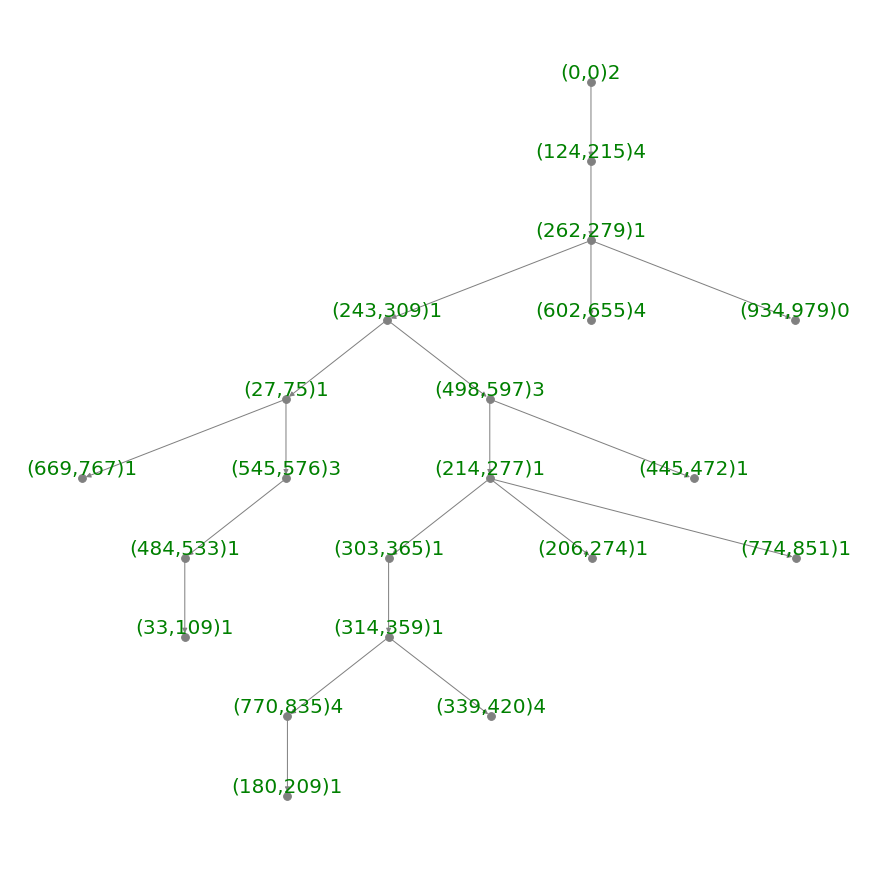

In [527]:
plt.figure(3, figsize=(12,12))
pos = graphviz_layout(tree, prog = "dot")
nx.draw(tree, pos = pos, with_labels=True, node_color = "grey", node_size = 60, verticalalignment = "bottom",
       font_size=20, edge_color="grey", font_color="green")
plt.show()